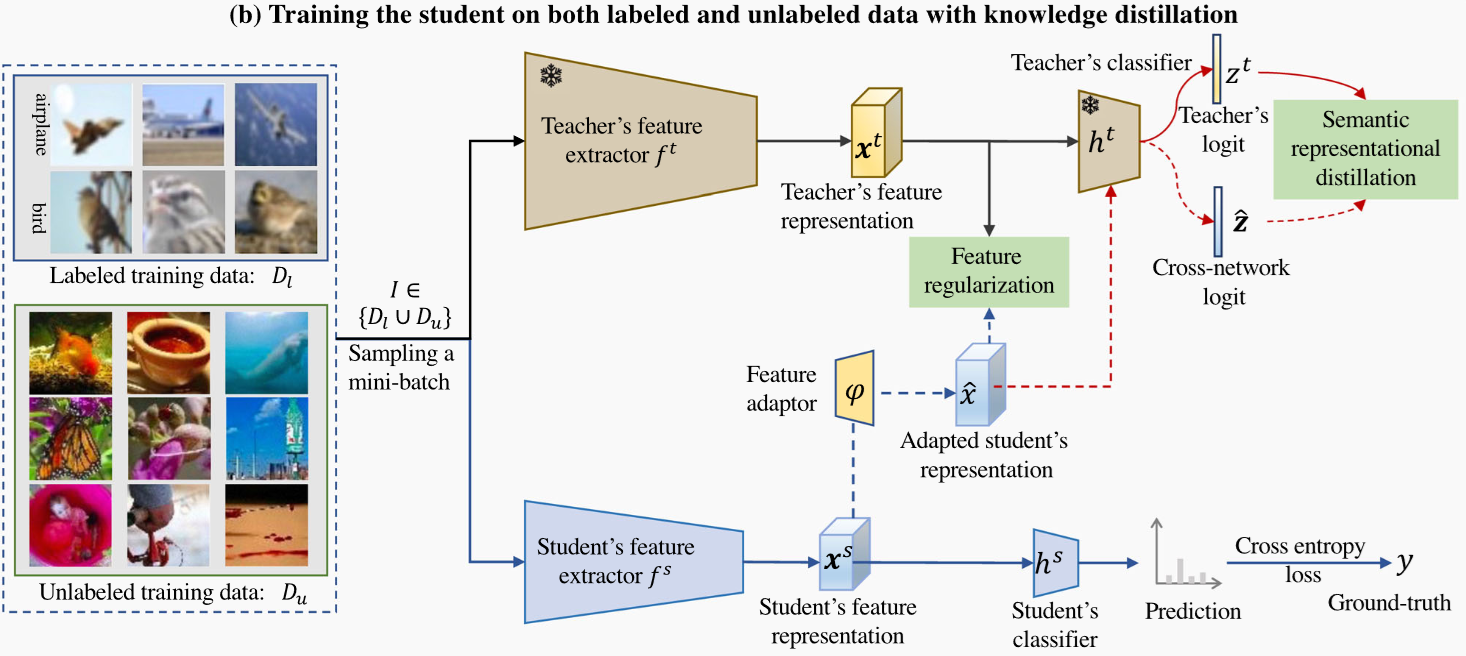

Distillation learning has been one of the widely used methods in transfer learning, and the usual method consists of two models: a teacher model that has been trained throughly on high amounts of data that marks our expectations in terms of accuracy, and a student model that we want to distill the knowledge to which usally is either difficult to train from scratch (like transferring knowledge from CNNs to Transformer based models as these models are data hungry and can't converge with same amount of data as CNNs) or we want smaller models to have same accuracy as larger ones but being smaller and faster.

The usual method is that the output vector of the teacher is used as the ground truth label for the student and it helps to transfer some parts of the data probability distribution acrross the classes to student and resolves the need for the student model to learn them.

However, because the usual method only uses class representations, it doesn't contain enough feature level information, while we can train the student to output featurres (and not classes) similar to the teacher.

The SRD model (Semantic Representational Distillation) proposed by Yang et al. in the paper "Knowledge Distillation Meets Open-Set Semi-Supervised Learning", addresses this by proposing a new method to train the student. The main idea is to use student's features to get the similar output from teacher's classifier as the teacher itself. This way, we can be sure that student have learnt the feature representations of the input and not just output probability distributions.

To map the student output features with teacher features, we use a feature adapter (which also need to be trained) that acts as both a mediator to match the dimensions of the two, and also acting as nonlinearity to transform from the student model's feature space to teacher's feature space.

Another advantage of learning representations, is that we can use unlabeled data to train as well, because the similarity of feature representation betweeen teacher and student is optimized in loss and it does not matter how the class outputs are going to be, so we can use larger databases to train the student.

How is it acheived is by using the loss function:

\begin{equation}
\mathcal{L}_{l+u} = \mathcal{L}_{ce}(D_l) + \alpha \mathcal{L}_{srd}(D_l \cup D_u) + \beta \mathcal{R}(D_l \cup D_u)
\end{equation}

in which $\mathcal{L}_{ce}(D_l)$ is the normal classification loss for student trained on labeled data $D_l$ for which we use Cross-Entropy loss, $\mathcal{L}_{srd}(D_l \cup D_u)$ is the loss function of loss between outputs of teacher classifier from both adapted student features and teacher features, and the $\mathcal{R}(D_l \cup D_u)$ is the adaption loss by the adaptor that maps the features from student to the teacher. The last two terms are using unlabelled data as well as labeled data, and both are calculated by Mean Square Error (MSE) loss. And $\alpha$ and $\beta$ are parameters to control the impact of each loss.

One modifications in this code, only the teacher's classifier have been trained with 20 epoches before training the whole teacher model ,because model is pretrained and empty weights for classifier might have negative impact on somewhat optimal pretrained weight. After that, the teacher model has been trained for 350 epoches on CIFAR-10 with learning rate reduction at stages [150, 250, 320] as mentioned in paper. Another modification is the introduction of cosine annealing scheduler for $\alpha$ and $\beta$ parameters, as the model starts to learn, these parameters reduce gradually.

In the end, 6 outputs are tested, all with the 20 epoches:

1- $\alpha$ = 0 and $\beta$ = 0 

2- No classification loss and pure SRD (test is done using teacher classifier because student classifier has not been trained)

3- $\alpha$ = 1 and $\beta$ = 1

4- $\alpha$ = 3 and $\beta$ = 3

5- $\alpha$ = 3 and $\beta$ = 3 with cosine annealing scheduler from 3 to 0

6- $\alpha$ = 3 and $\beta$ = 3 with cosine annealing scheduler from 0 to 3

In [1]:
import os
import torch
import math
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, ConcatDataset
from tqdm import tqdm
import torchvision.models as models
import matplotlib.pyplot as plt

In [2]:
class MaskedCIFAR100():
    def __init__(self, transform):
        self.cifar100_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
        
    def __len__(self):
        return len(self.cifar100_dataset)
    
    def __getitem__(self, idx):
        image, _ = self.cifar100_dataset[idx]
        return image, -1

# Data Augmentation 
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762])
])

# Labelled and supervised dataset (CIFAR-10) 
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Unsupervised dataset (CIFAR-100) 
cifar100_train_dataset = MaskedCIFAR100(transform)
srd_train_dataset = ConcatDataset([train_dataset, cifar100_train_dataset])

train_loader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=True, num_workers=4)
srd_train_loader = DataLoader(dataset=srd_train_dataset, batch_size=512, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=512, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Identity layer used for removing last layer of teacher (Classifier)
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

# General Classifier used for both teacher and student
class classifier(nn.Module):
    def __init__(self, teacher_model, num_classes):
        super(classifier, self).__init__()
        self.classifier = nn.Linear(teacher_model.fc.in_features, num_classes)
        
    def forward(self, x):
        return self.classifier(x)
    
class Adaptor(nn.Module):
    def __init__(self, teacher_out_features_dim, student_out_features_dim):
        super(Adaptor, self).__init__()
        self.conv = nn.Conv2d(student_out_features_dim, teacher_out_features_dim, 1)
        self.relu = nn.ReLU()
        self.norm = nn.BatchNorm2d(teacher_out_features_dim)
        
    def forward(self, x):
        x = x[:,:, None, None]
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x).squeeze()
        return x

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Teacher model: ResNet50
num_classes = 10
teacher_model = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
teacher_classifier = classifier(teacher_model, num_classes)
teacher_model.fc = Identity()
teacher_model = nn.DataParallel(teacher_model).to(device)
teacher_classifier = nn.DataParallel(teacher_classifier).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 160MB/s] 


In [5]:
# Loss function for teacher training
criterion = nn.CrossEntropyLoss()

# Optimizer and scheduler setter for every training
def get_optimizer_and_scheduler(params, lr, step_size, opt="step"):
    optimizer = optim.SGD(params, lr=lr, momentum=0.9, weight_decay=5e-4)
    if opt == "step":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)
    elif opt == "mulstep":
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 250, 320], gamma=0.1)
    return optimizer, scheduler

In [6]:
def train_and_test_teacher(model, classifier, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    total_batches = len(train_loader)
    total_test_batches = len(test_loader)
    total_steps = epochs * (total_batches + total_test_batches)

    progress_bar = tqdm(total=total_steps, desc="Training", unit="batch", leave=False)
    
    train_losses = []
    test_accs = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            features = model(images) 
            outputs = classifier(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_correct += (outputs.max(1)[1] == labels).sum().item()
            train_total += labels.size(0)

            train_acc = 100. * train_correct / train_total
            progress_bar.update(1)
            progress_bar.set_description(f"Epoch {epoch+1}/{epochs}")
            progress_bar.set_postfix(train_loss=(running_loss/total_batches), train_acc=train_acc)

        scheduler.step()
        train_losses.append(running_loss / total_batches)

        # Testing loop
        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                features = model(images)  # Extract features from the model
                outputs = classifier(features)  # Classify using the teacher_classifier

                test_correct += (outputs.max(1)[1] == labels).sum().item()
                test_total += labels.size(0)

                progress_bar.update(1)

        test_acc = 100. * test_correct / test_total
        test_accs.append(test_acc)

    progress_bar.close()

    # Plotting after the training ends
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), test_accs, label='Test Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [7]:
model_save_path = "/kaggle/working/teacher_model.pth"
classifier_save_path = "/kaggle/working/teacher_classifier.pth"

if os.path.exists(model_save_path) and os.path.exists(classifier_save_path):
    print("Saved model found. Loading the saved model...")
    teacher_model.module.load_state_dict(torch.load(model_save_path, weights_only=True))
    teacher_classifier.module.load_state_dict(torch.load(classifier_save_path, weights_only=True))
    print("Model loaded. Skipping training.")
else:
    print("No saved model found. Proceeding with training...")

    for param in teacher_model.module.parameters():
        param.requires_grad = False  # Freeze teacher_model parameters
    
    # Train teacher's classifier for only 20 epoches
    optimizer, scheduler = get_optimizer_and_scheduler(teacher_classifier.module.parameters(), lr=0.01, step_size=20)
    print("Training the last layer only for 20 epochs...")
    train_and_test_teacher(teacher_model, teacher_classifier, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs=20)

    # Phase 2: Train the entire network (Teacher's Model and Teacher's Classifier) for 350 epochs
    for param in teacher_model.module.parameters():
        param.requires_grad = True 

    optimizer, scheduler = get_optimizer_and_scheduler(
        list(teacher_model.parameters()) + list(teacher_classifier.parameters()),
        lr=0.1, step_size=10, opt = "mulstep"
    )
    print("Training the entire network for 350 epochs...")
    train_and_test_teacher(teacher_model, teacher_classifier, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs=350)

    torch.save(teacher_model.module.state_dict(), model_save_path)
    torch.save(teacher_classifier.module.state_dict(), classifier_save_path)
    print(f"Models saved to: {model_save_path} and {classifier_save_path}")

Saved model found. Loading the saved model...
Model loaded. Skipping training.


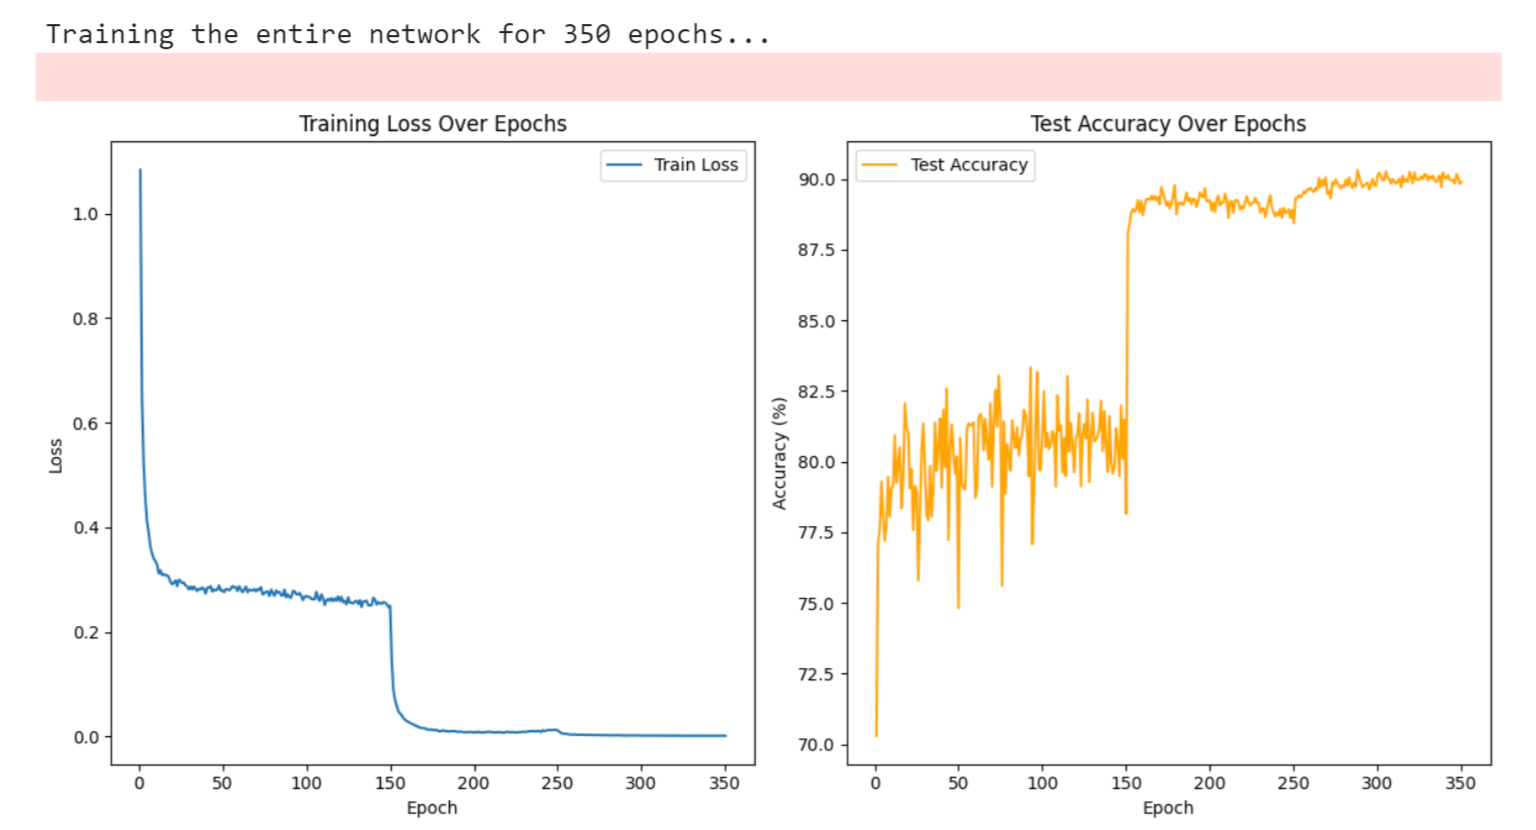

I had to restart the model so I uploaded the training chart I've got from trainig the teacher with 350 epoches

In [8]:
# Defining Student Model, Student  Classifier and Student Adaptor
student_model = models.resnet18(weights = None)
student_classifier = classifier(student_model, num_classes)
student_model.fc = Identity()
student_model = nn.DataParallel(student_model).to(device)
student_classifier = nn.DataParallel(student_classifier).to(device)
student_adaptor = Adaptor(2048,512)
student_adaptor = nn.DataParallel(student_adaptor).to(device)

We can have either of 3 loss functions (in this code MSe without softmax have been used, the second approach in the paper)

1- $\mathcal{L}_{srd}^{kl} = - \sum_{k=1}^{K} p_{t}^{k} \log \hat{p}_{t}^{k}$  which is matching the logits of teacher and student after applying softmax

2- $\mathcal{L}_{srd}^{mse} = \left\| z_t - \hat{z} \right\|^2 = \left\| W^t \left( x_t - \varphi(x_s) \right) \right\|^2
$ which is msse loss between logits beforre applying softmax

3- $\mathcal{L}_{srd}^{pmse} = \left\| p_t - \hat{p} \right\|^2$ which is same as second one but after applying softmax

In [9]:
class SRDLoss(nn.Module):
    def __init__(self, SRD_objective="mse", alpha = 1, beta = 1):
        super(SRDLoss, self).__init__()
        self.SRD_objective = SRD_objective
        self.softmax = nn.Softmax()
        self.alpha = alpha
        self.beta = beta
        self.ce = nn.CrossEntropyLoss()
        self.mse = nn.MSELoss()
    
    def forward(self, teacher_features, student_features, student_features_adapted, teacher_logits, student_logits, cross_network_logits, targets):
        Lce = self.ce(student_logits, targets)
        R = self.mse(student_features_adapted,teacher_features)
        
        match self.SRD_objective:
            case "mse":
                Lsrd = self.mse(student_features_adapted, teacher_features)
            case "kl":
                teacher_preds = self.softmax(teacher_logits)
                student_preds = self.softmax(cross_network_logits)
                Lsrd = self.ce(teacher_logits, student_logits)
            case "pmse":
                teacher_preds = self.softmax(teacher_logits)
                student_preds = self.softmax(cross_network_logits)
                Lsrd = self.mse(teacher_logits, student_logits)
                
        loss = Lce + self.alpha * Lsrd + self.beta * R
                
        return loss
        

In [10]:
class CosineAnnealingParamScheduler:
    def __init__(self, start_value, end_value, num_epochs):
        self.start_value = start_value
        self.end_value = end_value
        self.num_epochs = num_epochs
        self.current_epoch = 0

    def step(self):
        if self.current_epoch < self.num_epochs:
            cos_inner = (math.pi * self.current_epoch) / self.num_epochs
            cos_out = math.cos(cos_inner) + 1
            value = self.end_value + 0.5 * (self.start_value - self.end_value) * cos_out
            self.current_epoch += 1
            return value
        else:
            return self.end_value
        
def reset_parameters(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [11]:
softmax = nn.Softmax()
mse = nn.MSELoss()
ce = nn.CrossEntropyLoss()

In [12]:
def train_and_test_SRD(train_loader, test_loader, optimizer, scheduler, device, epochs, hyperparams):
    alpha_scheduler = CosineAnnealingParamScheduler(start_value=hyperparams[0][0], end_value=hyperparams[0][1], num_epochs=hyperparams[0][2])
    beta_scheduler = CosineAnnealingParamScheduler(start_value=hyperparams[1][0], end_value=hyperparams[1][1], num_epochs=hyperparams[1][2])
    total_batches = len(train_loader)

    total_test_batches = len(test_loader)
    total_steps = epochs * (total_batches + total_test_batches)

    progress_bar = tqdm(total=total_steps, desc="Training", unit="batch", leave=False)
    test_acc = 0 
    avg_test_loss = 0
    
    cross_network_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        alpha = alpha_scheduler.step()
        beta = beta_scheduler.step()
        student_model.train()
        student_classifier.train()
        student_adaptor.train()
        teacher_model.eval()
        teacher_classifier.eval()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        epoch_cross_network_loss = 0.0

        # Training loop
        for images, labels in srd_train_loader:
            images, labels = images.to(device), labels.to(device)

            # Mask for unsupervised samples
            mask = labels != -1
            optimizer.zero_grad()
            teacher_features = teacher_model(images)
            student_features = student_model(images)
            student_features_adapted = student_adaptor(student_features)
            teacher_logits = teacher_classifier(teacher_features)
            cross_logits = teacher_classifier(student_features_adapted)
            student_logits = student_classifier(student_features)
            if hyperparams[2]!=0:
                outputs = softmax(student_logits) 
            else:
                outputs = softmax(cross_logits)

            # Compute the adaptation loss and classification loss and cross network loss
            cross_network_loss = mse(teacher_logits, cross_logits)
            adaptation_loss = mse(student_features_adapted, teacher_features)
            classification_loss = ce(student_logits[mask], labels[mask])  * hyperparams[2]
            loss = classification_loss + alpha * cross_network_loss + beta * adaptation_loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_cross_network_loss += cross_network_loss.item()
            train_correct += (outputs[mask].max(1)[1] == labels[mask]).sum().item()
            train_total += labels[mask].size(0)
            train_acc = 100. * train_correct / train_total
            progress_bar.update(1)
            progress_bar.set_description(f"Epoch {epoch+1}/{epochs}")
            progress_bar.set_postfix(train_loss=(running_loss/total_batches), train_acc=train_acc, test_acc=test_acc, test_loss=avg_test_loss)

        cross_network_losses.append(epoch_cross_network_loss / total_batches)

        scheduler.step()

        # Testing loop
        teacher_model.eval()
        student_model.eval()
        teacher_classifier.eval()
        student_adaptor.eval()
        student_classifier.eval()
        
        test_correct = 0
        test_total = 0
        test_running_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                student_features = student_model(images)
                student_features_adapted = student_adaptor(student_features)
                teacher_features = teacher_model(images)
                teacher_logits = teacher_classifier(teacher_features)
                cross_logits = teacher_classifier(student_features_adapted)
                logits = student_classifier(student_features)
                if hyperparams[2]!=0:
                    outputs = softmax(logits) 
                else:
                    outputs = softmax(cross_logits)

                # Compute the adaptation loss and classification loss for the test set
                cross_network_loss = mse(teacher_logits, cross_logits)
                test_loss = cross_network_loss
                test_running_loss += test_loss.item()
                test_correct += (outputs.max(1)[1] == labels).sum().item()
                test_total += labels.size(0)

                progress_bar.update(1)

        test_acc = 100. * test_correct / test_total
        avg_test_loss = test_running_loss / total_test_batches
        test_accuracies.append(test_acc)
        progress_bar.set_postfix(train_loss=(running_loss / total_batches), train_acc=train_acc, 
                                 test_acc=test_acc, test_loss=avg_test_loss)

    progress_bar.close()
    
    # Plotting losses and accuracies
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), cross_network_losses, label="Cross-Network Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Cross-Network Loss over Epochs')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), test_accuracies, label="Test Accuracy", color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Training SRD model for 20 epochs...


Training:   0%|          | 0/4320 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


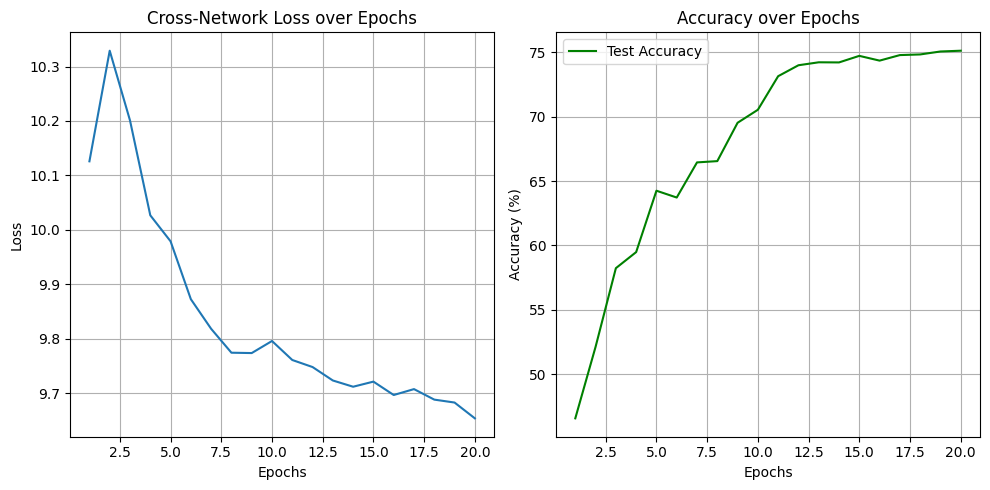

In [13]:
# Training only using classification loss

for param in teacher_model.module.parameters():
    param.requires_grad = False 
for param in teacher_classifier.module.parameters():
    param.requires_grad = False

optimizer, scheduler = get_optimizer_and_scheduler(
    list(student_model.parameters()) + list(student_classifier.parameters()) + list(student_adaptor.parameters()),
    lr=0.01, step_size=10)

epoches = 20
hyperparams = [[0,0,epoches],[0,0,epoches],1]
print(f"Training SRD model for {epoches} epochs...")
train_and_test_SRD(srd_train_loader, test_loader, optimizer, scheduler, device, epoches, hyperparams)

Training SRD model for 20 epochs...


Training:   0%|          | 0/4320 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


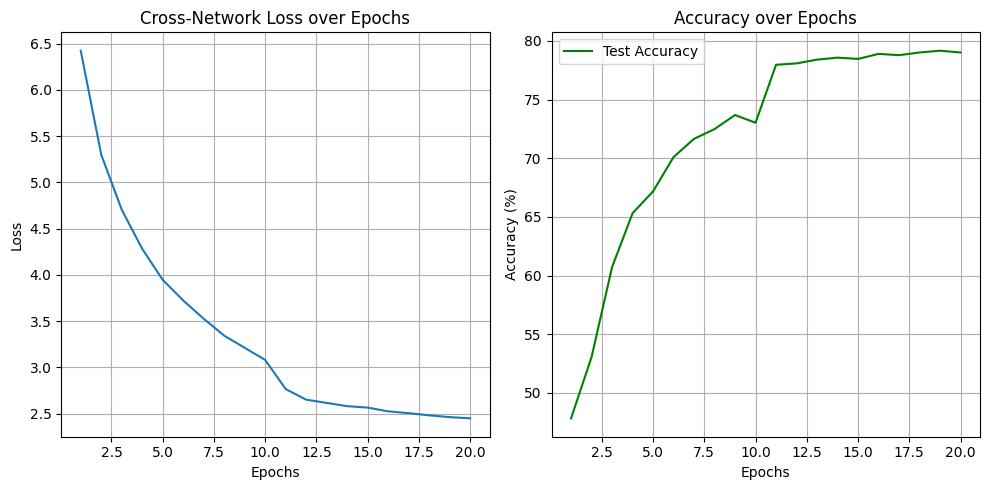

In [15]:
# Training only using SRD loss on Teacher Classifier

reset_parameters(student_classifier)
reset_parameters(student_adaptor)
reset_parameters(student_model)

optimizer, scheduler = get_optimizer_and_scheduler(
    list(student_model.parameters()) + list(student_classifier.parameters()) + list(student_adaptor.parameters()),
    lr=0.01, step_size=10)

epoches = 20
hyperparams = [[1,1,epoches],[1,1,epoches],0]
print(f"Training SRD model for {epoches} epochs...")
train_and_test_SRD(srd_train_loader, test_loader, optimizer, scheduler, device, epoches, hyperparams)

Training SRD model for 20 epochs...


Training:   0%|          | 0/4320 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


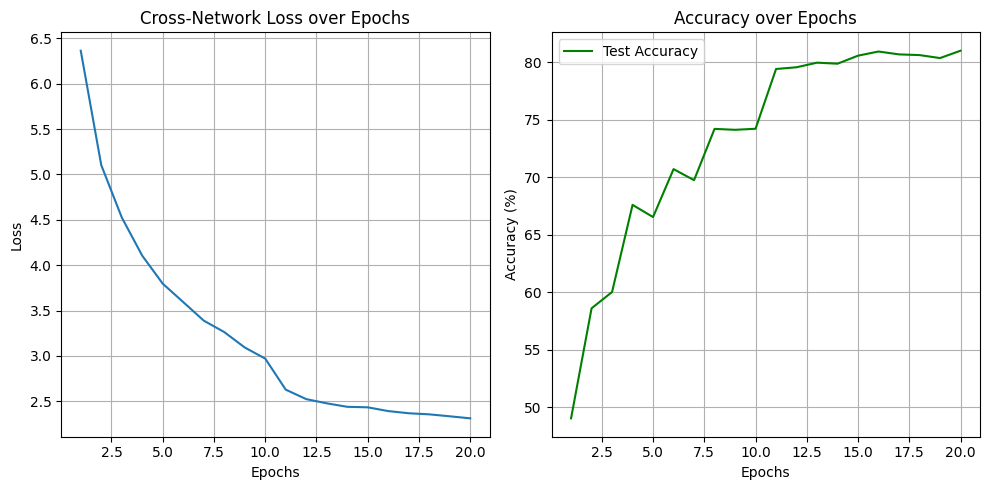

In [21]:
# Training with a=1 b=1 with no scheduler

reset_parameters(student_classifier)
reset_parameters(student_adaptor)
reset_parameters(student_model)
optimizer, scheduler = get_optimizer_and_scheduler(
    list(student_model.parameters()) + list(student_classifier.parameters()) + list(student_adaptor.parameters()),
    lr=0.01, step_size=10)

epoches = 20
hyperparams = [[1,1,epoches],[1,1,epoches],1]
print(f"Training SRD model for {epoches} epochs...")
train_and_test_SRD(srd_train_loader, test_loader, optimizer, scheduler, device, epoches, hyperparams)

Training SRD model for 20 epochs...


Training:   0%|          | 0/4320 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


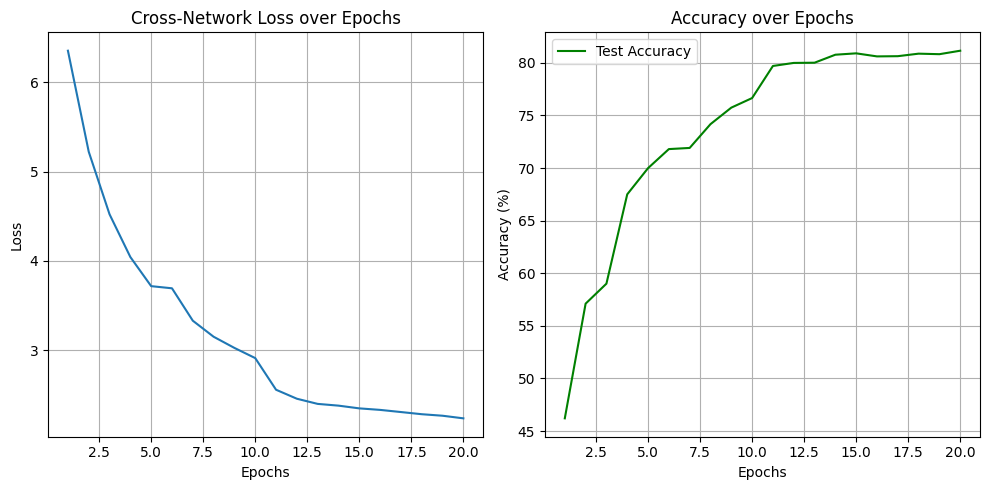

In [13]:
# Training with a=3 b=3 with no scheduler
 
reset_parameters(student_classifier)
reset_parameters(student_adaptor)
reset_parameters(student_model)

optimizer, scheduler = get_optimizer_and_scheduler(
    list(student_model.parameters()) + list(student_classifier.parameters()) + list(student_adaptor.parameters()),
    lr=0.01, step_size=10)

epoches = 20
hyperparams = [[3,3,epoches],[3,3,epoches],1]
print(f"Training SRD model for {epoches} epochs...")
train_and_test_SRD(srd_train_loader, test_loader, optimizer, scheduler, device, epoches, hyperparams)

Training SRD model for 20 epochs...


Training:   0%|          | 0/4320 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


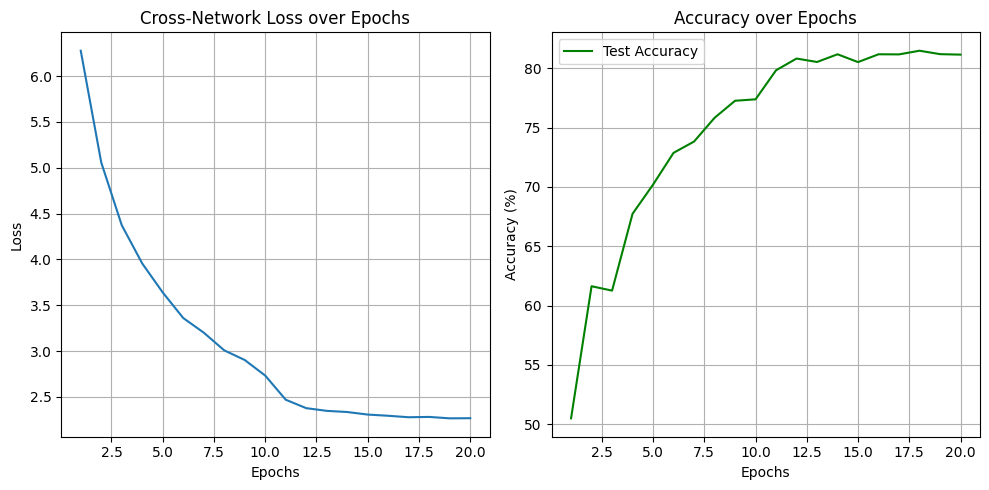

In [13]:
# Training with a=3 b=3 with scheduler

reset_parameters(student_classifier)
reset_parameters(student_adaptor)
reset_parameters(student_model)

optimizer, scheduler = get_optimizer_and_scheduler(
    list(student_model.parameters()) + list(student_classifier.parameters()) + list(student_adaptor.parameters()),
    lr=0.01, step_size=10)

epoches = 20
hyperparams = [[3,0,epoches],[3,0,epoches],1]
print(f"Training SRD model for {epoches} epochs...")
train_and_test_SRD(srd_train_loader, test_loader, optimizer, scheduler, device, epoches, hyperparams)

Training SRD model for 20 epochs...


Training:   0%|          | 0/4320 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


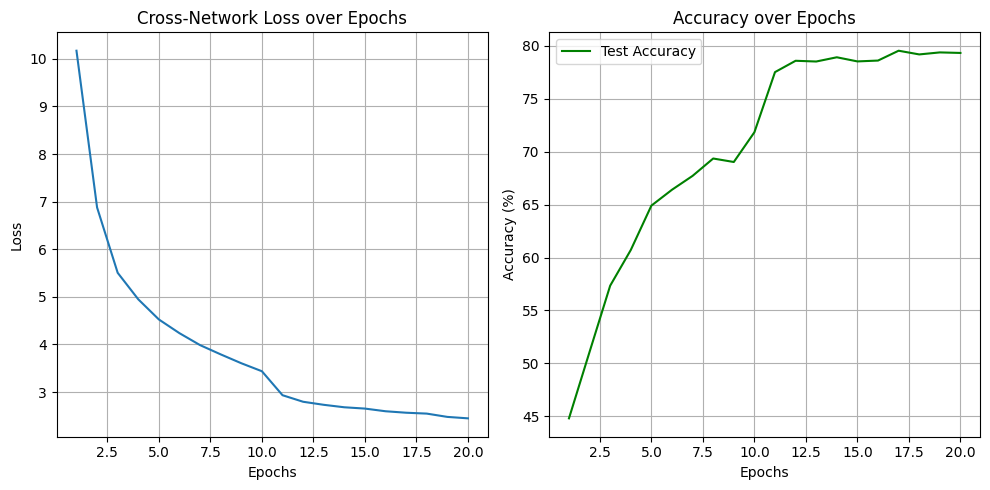

In [14]:
# Training with a=3 b=3 with reversed scheduler
 
reset_parameters(student_classifier)
reset_parameters(student_adaptor)
reset_parameters(student_model)

optimizer, scheduler = get_optimizer_and_scheduler(
    list(student_model.parameters()) + list(student_classifier.parameters()) + list(student_adaptor.parameters()),
    lr=0.01, step_size=10)

epoches = 20
hyperparams = [[0,3,epoches],[0,3,epoches],1]
print(f"Training SRD model for {epoches} epochs...")
train_and_test_SRD(srd_train_loader, test_loader, optimizer, scheduler, device, epoches, hyperparams)